In [1]:
#Montaje de Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Lectura y preprocesamiento de imágenes

In [2]:
#Importación de librerías y configuración
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Directorio de datasets:
# Este dataset esta perfectamente balanceado entre las clases 'normal' y 'tuberculosis' con la misma cantidad de imagenes del mismo dataset.
# Contenido: 4 in test - 696 in train para ambas clases.
dataset_path = '/content/drive/My Drive/proyecto2024_datasets/2.Tuberculosis-(TB)-Chest X-ray-Database-misma-cantidad/chest_xray/train'

# Tamaño al que se redimencionan las imágenes para que sean uniformes
IMG_SIZE = (512, 512)

# Función para cargar imágenes y convertirlas en arrays
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('L')  # Convertir a escala de grises
            img = img.resize(IMG_SIZE)  # Redimensionar las imágenes
            img_array = np.array(img).flatten()  # Convertir la imagen a un vector 1D
            images.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f'Error al procesar {filename}: {e}')
    return images, labels

# Cargar imágenes de las carpetas 'NORMAL' y 'TUBERCULOSIS' asignando etiquetas (0 para NORMAL y 1 para TUBERCULOSIS).
normal_images, normal_labels = load_images_from_folder(os.path.join(dataset_path, 'NORMAL'), 0)
tuberculosis_images, tuberculosis_labels = load_images_from_folder(os.path.join(dataset_path, 'TUBERCULOSIS'), 1)

# Combinar las imágenes y las etiquetas
X = normal_images + tuberculosis_images
y = normal_labels + tuberculosis_labels

# Convertir a arrays de NumPy
X = np.array(X)
y = np.array(y)

# Separar en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)





#Entrenamiento y evaluación

In [3]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Modelo SVM
svm_model = SVC(kernel='linear', probability=True) #Crea un modelo de SVM (Support Vector Machine) con un kernel lineal. Modelo para clasificación
svm_model.fit(X_train, y_train) #Entrena el modelo con los datos de entrenamiento

# Predicciones originales en el conjunto de validación
y_pred = svm_model.predict(X_val)

# Evaluación del modelo sin ajustar el threshold
print("SVM Accuracy:", accuracy_score(y_val, y_pred)) #Calcula la precisión general del modelo (proporción de predicciones correctas)
print(classification_report(y_val, y_pred)) #informe detallado con presicion, recall, f1 score para ambas clases.


SVM Accuracy: 0.9498207885304659
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       143
           1       0.96      0.93      0.95       136

    accuracy                           0.95       279
   macro avg       0.95      0.95      0.95       279
weighted avg       0.95      0.95      0.95       279



In [ ]:
# Predicciones con probabilidades en el conjunto de validación
y_pred_proba = svm_model.predict_proba(X_val)  # Devuelve las probabilidades para cada clase

# Mostrar las primeras predicciones con sus porcentajes de confianza
for i in range(5):  # Muestra solo las primeras 5 como ejemplo
    print(f"Predicción: {y_pred[i]}, Probabilidad de clase 0 (normal): {y_pred_proba[i][0]:.2f}, Probabilidad de clase 1 (tuberculosis {y_pred_proba[i][1]:.2f}")

Predicción: 1, Probabilidad de clase 0 (normal): 0.00, Probabilidad de clase 1 (tuberculosis 1.00
Predicción: 0, Probabilidad de clase 0 (normal): 0.99, Probabilidad de clase 1 (tuberculosis 0.01
Predicción: 0, Probabilidad de clase 0 (normal): 0.96, Probabilidad de clase 1 (tuberculosis 0.04
Predicción: 1, Probabilidad de clase 0 (normal): 0.00, Probabilidad de clase 1 (tuberculosis 1.00
Predicción: 0, Probabilidad de clase 0 (normal): 0.74, Probabilidad de clase 1 (tuberculosis 0.26


# Pruebas manuales

In [ ]:
image_path = '/content/drive/My Drive/proyecto2024_datasets/2.Tuberculosis-(TB)-Chest X-ray-Database-misma-cantidad/chest_xray/test/NORMAL/Normal-406.png'

def preprocess_image(image_path):
    try:
        img = Image.open(image_path).convert('L')
        img = img.resize(IMG_SIZE)
        img_array = np.array(img).flatten()
        return np.array([img_array])
    except Exception as e:
        print(f"Error al procesar la imagen: {e}")
        return None

image_to_predict = preprocess_image(image_path)


In [ ]:
if image_to_predict is not None:
    prediction = svm_model.predict(image_to_predict)
    label = "NORMAL" if prediction == 0 else "TUBERCULOSIS"
    print(f"La imagen seleccionada ha sido clasificada como: {label}")
else:
    print("No se pudo procesar la imagen.")


La imagen seleccionada ha sido clasificada como: NORMAL


## Predicciones con probabilidades

In [4]:
# Predicciones con probabilidades en el conjunto de validación
y_pred_proba = svm_model.predict_proba(X_val)  # Devuelve las probabilidades para cada clase
y_pred = svm_model.predict(X_val)  # Devuelve las predicciones de clase

# Listas para almacenar los resultados
acertadas_normal = []
acertadas_tuberculosis = []
fallidas_normal = []
fallidas_tuberculosis = []

# Clasificación de las predicciones según si son correctas o incorrectas
for i in range(len(y_val)):
    etiqueta_real = 'Normal' if y_val[i] == 0 else 'Tuberculosis'
    prediccion = 'Normal' if y_pred[i] == 0 else 'Tuberculosis'
    probabilidad_normal = y_pred_proba[i][0] * 100
    probabilidad_tuberculosis = y_pred_proba[i][1] * 100

    resultado = (f"Etiqueta real: {etiqueta_real}, Predicción: {prediccion}, "
                 f"Probabilidad de clase 0 (Normal): {probabilidad_normal:.2f}%, "
                 f"Probabilidad de clase 1 (Tuberculosis): {probabilidad_tuberculosis:.2f}%")

    # Clasificar según la predicción
    if y_val[i] == y_pred[i]:  # Predicción correcta
        if y_val[i] == 0:  # Clase "Normal"
            acertadas_normal.append(resultado)
        else:  # Clase "Tuberculosis"
            acertadas_tuberculosis.append(resultado)
    else:  # Predicción incorrecta
        if y_val[i] == 0:  # Clase "Normal" etiquetada incorrectamente
            fallidas_normal.append(resultado)
        else:  # Clase "Tuberculosis" etiquetada incorrectamente
            fallidas_tuberculosis.append(resultado)

# Imprimir los resultados ordenados
print("Predicciones acertadas - Clase Normal:")
for r in acertadas_normal:
    print(r)

print("\nPredicciones acertadas - Clase Tuberculosis:")
for r in acertadas_tuberculosis:
    print(r)

print("\nPredicciones fallidas - Clase Normal:")
for r in fallidas_normal:
    print(r)

print("\nPredicciones fallidas - Clase Tuberculosis:")
for r in fallidas_tuberculosis:
    print(r)



Predicciones acertadas - Clase Normal:
Etiqueta real: Normal, Predicción: Normal, Probabilidad de clase 0 (Normal): 99.27%, Probabilidad de clase 1 (Tuberculosis): 0.73%
Etiqueta real: Normal, Predicción: Normal, Probabilidad de clase 0 (Normal): 76.33%, Probabilidad de clase 1 (Tuberculosis): 23.67%
Etiqueta real: Normal, Predicción: Normal, Probabilidad de clase 0 (Normal): 99.92%, Probabilidad de clase 1 (Tuberculosis): 0.08%
Etiqueta real: Normal, Predicción: Normal, Probabilidad de clase 0 (Normal): 99.99%, Probabilidad de clase 1 (Tuberculosis): 0.01%
Etiqueta real: Normal, Predicción: Normal, Probabilidad de clase 0 (Normal): 99.94%, Probabilidad de clase 1 (Tuberculosis): 0.06%
Etiqueta real: Normal, Predicción: Normal, Probabilidad de clase 0 (Normal): 99.96%, Probabilidad de clase 1 (Tuberculosis): 0.04%
Etiqueta real: Normal, Predicción: Normal, Probabilidad de clase 0 (Normal): 70.88%, Probabilidad de clase 1 (Tuberculosis): 29.12%
Etiqueta real: Normal, Predicción: Normal,

# Image Viewing

Visualización de la primera imagen de la clase X

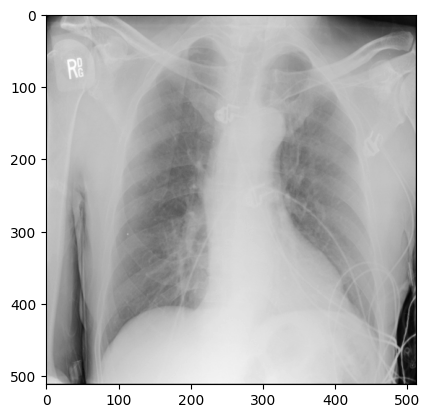

In [ ]:
#toma la primera imagen del dataset, la reorganiza en una matriz de 512x512 píxeles y luego la visualiza en una escala de grises utilizando matplotlib
import matplotlib.pyplot as plt
img = X[0].reshape(512, 512)
plt.imshow(img, cmap='gray')
plt.show()

Primeras 50 imágenes del dataset X

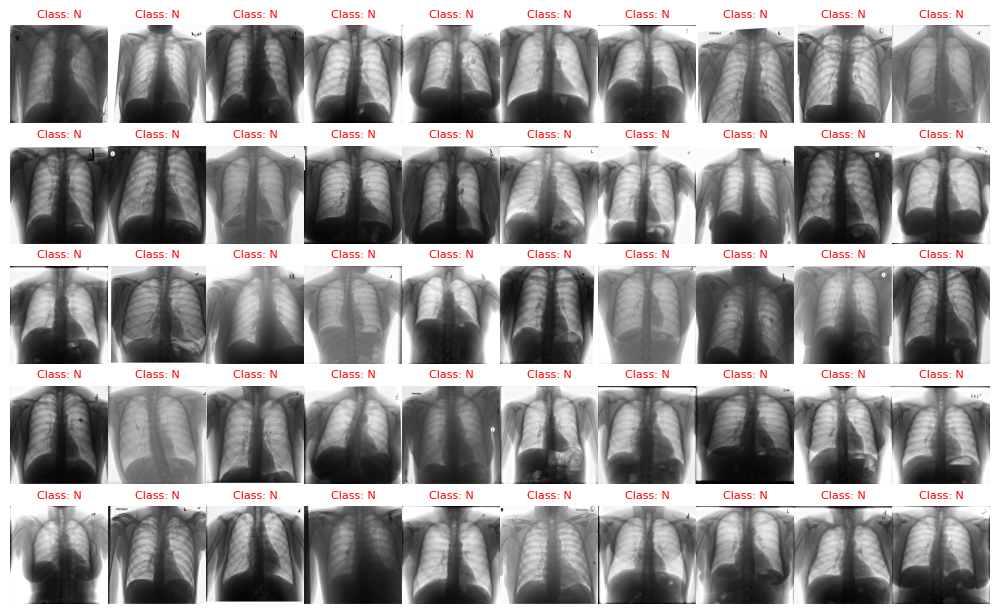

In [ ]:
import matplotlib.pyplot as plt

def plot_digit(image_data, label):
    image = image_data.reshape(512, 512)
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    # Título con clase (N para Normal y P para Tuberculosis)
    plt.title(f"Class: {'N' if label == 0 else 'T'}", fontsize=8, color='red')

plt.figure(figsize=(10, 5))  # Tamaño ajustado para reducir el espacio

# Mostrar las primeras 50 imágenes con sus etiquetas
for idx, (image_data, label) in enumerate(zip(X[:50], y[:50])):
    plt.subplot(5, 10, idx + 1)  # Cuadrícula de 5 filas y 10 columnas
    plot_digit(image_data, label)

# espaciado entre las imágenes
plt.subplots_adjust(left=0.01, right=0.99, top=1.2, bottom=0.01, wspace=0, hspace=0.05)

plt.show()




#Cross-Validaton

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm_model, X_train, y_train, cv=3, scoring="accuracy")
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Scores: [0.94609164 0.92722372 0.94878706]
Mean Accuracy: 0.9407008086253369


# Evaluación de Presicion, Recall y Threshold

*Reimpresión de métricas sin ajustar el threshold*

In [ ]:
# Reutilización de las predicciones para imprimir las métricas adicionales
print("\nRe-imprimiendo el reporte de clasificación:")
print(classification_report(y_val, y_pred))



Re-imprimiendo el reporte de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       143
           1       0.96      0.93      0.95       136

    accuracy                           0.95       279
   macro avg       0.95      0.95      0.95       279
weighted avg       0.95      0.95      0.95       279



##Cálculos y gráfica

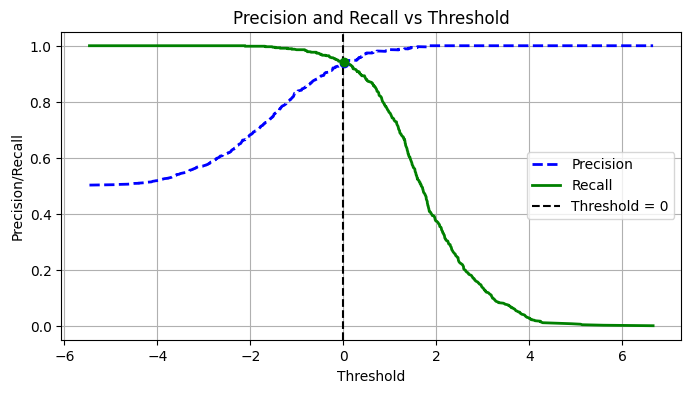

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Obtener los scores de decisión usando decision_function() con validación cruzada
y_scores = cross_val_predict(svm_model, X_train, y_train, cv=3, method="decision_function")

# Calcular precisión, recall y los umbrales
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

# Definir el umbral a visualizar
threshold = 0

# Crear el gráfico de precisión y recall vs umbral
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

# Línea vertical para el umbral actual
plt.axvline(x=threshold, color='k', linestyle='--', label=f'Threshold = {threshold}')

# Marcar los valores de precisión y recall en el umbral seleccionado
idx = (thresholds >= threshold).argmax()  # Encuentra el índice del umbral seleccionado
plt.plot(thresholds[idx], precisions[idx], "bo")  # Punto en Precision
plt.plot(thresholds[idx], recalls[idx], "go")     # Punto en Recall

# Configurar el gráfico: límites, leyenda, etiquetas y grilla
plt.grid()
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.legend(loc="center right")
plt.title("Precision and Recall vs Threshold")

plt.show()


##Hacer predicciones con un threshold ajustado



In [ ]:
# Obtener los scores de decisión para el conjunto de validación
y_val_scores = svm_model.decision_function(X_val)

# Elegir un nuevo threshold
new_threshold = -1

# Generar predicciones ajustando el threshold manualmente
y_pred_threshold = (y_val_scores > new_threshold).astype(int)

# Evaluar con el nuevo threshold
print(classification_report(y_val, y_pred_threshold))

#Este proceso permite optimizar el rendimiento del modelo para los casos en los que interese más el recall (detección de tuberculosis) o la precision (evitar falsos positivos).

              precision    recall  f1-score   support

           0       0.97      0.83      0.89       143
           1       0.85      0.97      0.90       136

    accuracy                           0.90       279
   macro avg       0.91      0.90      0.90       279
weighted avg       0.91      0.90      0.90       279



## Comparativa de metricas antes y después del ajuste del threshold

In [ ]:
from sklearn.metrics import classification_report

report_sin_umbral = classification_report(y_val, y_pred, output_dict=True)
report_con_umbral = classification_report(y_val, y_pred_threshold, output_dict=True)

print("Reporte de clasificación sin umbral ajustado:")
print("------------------------------------------------")
print(f"Precisión (0): {report_sin_umbral['0']['precision']:.4f}")
print(f"Recall (0): {report_sin_umbral['0']['recall']:.4f}")
print(f"F1 Score (0): {report_sin_umbral['0']['f1-score']:.4f}\n")
print(f"Precisión (1): {report_sin_umbral['1']['precision']:.4f}")
print(f"Recall (1): {report_sin_umbral['1']['recall']:.4f}")
print(f"F1 Score (1): {report_sin_umbral['1']['f1-score']:.4f}")
print(f"Accuracy: {report_sin_umbral['accuracy']:.4f}")

print("\nReporte de clasificación con umbral ajustado:")
print("------------------------------------------------")
print(f"Precisión (0): {report_con_umbral['0']['precision']:.4f}")
print(f"Recall (0): {report_con_umbral['0']['recall']:.4f}")
print(f"F1 Score (0): {report_con_umbral['0']['f1-score']:.4f}\n")
print(f"Precisión (1): {report_con_umbral['1']['precision']:.4f}")
print(f"Recall (1): {report_con_umbral['1']['recall']:.4f}")
print(f"F1 Score (1): {report_con_umbral['1']['f1-score']:.4f}")
print(f"Accuracy: {report_con_umbral['accuracy']:.4f}")


Reporte de clasificación sin umbral ajustado:
------------------------------------------------
Precisión (0): 0.9388
Recall (0): 0.9650
F1 Score (0): 0.9517

Precisión (1): 0.9621
Recall (1): 0.9338
F1 Score (1): 0.9478
Accuracy: 0.9498

Reporte de clasificación con umbral ajustado:
------------------------------------------------
Precisión (0): 0.9675
Recall (0): 0.8322
F1 Score (0): 0.8947

Precisión (1): 0.8462
Recall (1): 0.9706
F1 Score (1): 0.9041
Accuracy: 0.8996


#Detectar imágenes duplicadas usando hashing

In [ ]:
import os
import hashlib
from collections import defaultdict

# Función para calcular el hash de una imagen
def hash_image(image_path):
    with open(image_path, 'rb') as img_file:
        img_hash = hashlib.md5(img_file.read()).hexdigest()
    return img_hash

# Función para buscar imágenes duplicadas en un directorio
def find_duplicates_in_directory(directory):
    hashes = defaultdict(list)  # Diccionario para almacenar hashes y sus rutas
    for foldername, _, filenames in os.walk(directory):
        for filename in filenames:
            img_path = os.path.join(foldername, filename)
            img_hash = hash_image(img_path)
            hashes[img_hash].append(img_path)

    duplicates = {k: v for k, v in hashes.items() if len(v) > 1}  # Filtrar duplicados
    return duplicates

# Ruta del directorio donde estan las imagenes
dataset_path = '/content/drive/My Drive/proyecto2024_datasets/2.Tuberculosis-(TB)-Chest X-ray-Database-misma-cantidad/chest_xray/train'
duplicates = find_duplicates_in_directory(dataset_path)

# Mostrar las imágenes duplicadas
for img_hash, paths in duplicates.items():
    print(f"Hash: {img_hash}")
    for path in paths:
        print(f" - {path}")


Hash: 13ad2e91b8a719fa6ce0e87a4ea0b8b1
 - /content/drive/My Drive/proyecto2024_datasets/2.Tuberculosis-(TB)-Chest X-ray-Database-misma-cantidad/chest_xray/train/TUBERCULOSIS/Tuberculosis-348.png
 - /content/drive/My Drive/proyecto2024_datasets/2.Tuberculosis-(TB)-Chest X-ray-Database-misma-cantidad/chest_xray/train/TUBERCULOSIS/Tuberculosis-346.png
Hash: ab7b3732a223c780a3af4307583878c8
 - /content/drive/My Drive/proyecto2024_datasets/2.Tuberculosis-(TB)-Chest X-ray-Database-misma-cantidad/chest_xray/train/TUBERCULOSIS/Tuberculosis-244.png
 - /content/drive/My Drive/proyecto2024_datasets/2.Tuberculosis-(TB)-Chest X-ray-Database-misma-cantidad/chest_xray/train/TUBERCULOSIS/Tuberculosis-243.png
Hash: 11c7238f135a666dfe39591086fa0320
 - /content/drive/My Drive/proyecto2024_datasets/2.Tuberculosis-(TB)-Chest X-ray-Database-misma-cantidad/chest_xray/train/TUBERCULOSIS/Tuberculosis-509.png
 - /content/drive/My Drive/proyecto2024_datasets/2.Tuberculosis-(TB)-Chest X-ray-Database-misma-cantida

# Curva ROC y AUC

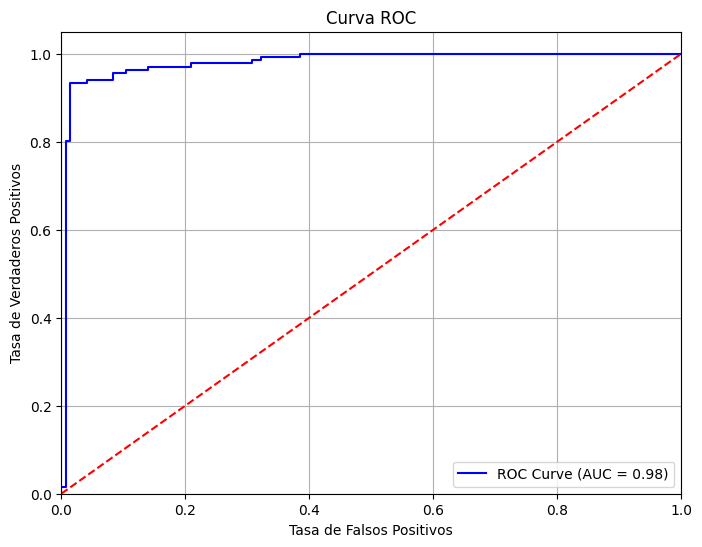

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# y_val_scores = svm_model.decision_function(X_val) da la distancia de cada punto de datos a la frontera de decisión.

# Calcular los valores de la curva ROC
fpr, tpr, thresholds = roc_curve(y_val, y_val_scores) # devuelve las tasas de falsos positivos (FPR) y verdaderos positivos (TPR) para varios umbrales.

#  Calcular el AUC (área bajo la curva ROC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()


#Visualización y conteo de aciertos y errores

Mostrar qué imágenes el modelo clasifica como "Normal" o "Tuberculosis", así como la etiqueta verdadera de cada imagen en el conjunto de test

In [ ]:
# Definimos el directorio de prueba
test_dir = '/content/drive/My Drive/proyecto2024_datasets/2.Tuberculosis-(TB)-Chest X-ray-Database-misma-cantidad/chest_xray/test'

# Cargar imágenes de prueba de las carpetas 'NORMAL' y 'TUBERCULOSIS' asignando etiquetas (0 para NORMAL y 1 para TUBERCULOSIS)
test_normal_images, test_normal_labels = load_images_from_folder(os.path.join(test_dir, 'NORMAL'), 0)
test_tuberculosis_images, test_tuberculosis_labels = load_images_from_folder(os.path.join(test_dir, 'TUBERCULOSIS'), 1)

# Combinar las imágenes y las etiquetas del conjunto de prueba
X_test = test_normal_images + test_tuberculosis_images
y_test = test_normal_labels + test_tuberculosis_labels

# Convertir a arrays de NumPy
X_test = np.array(X_test)
y_test = np.array(y_test)

# Realizar predicciones con el modelo ya entrenado
y_pred = svm_model.predict(X_test)

# Etiquetas
label_map = {0: 'Normal', 1: 'Tuberculosis'}

# Mostrar los resultados
for i in range(len(X_test)):
    prediccion = label_map[y_pred[i]]  # Predicción del modelo
    etiqueta_real = label_map[y_test[i]]  # Etiqueta verdadera
    print(f"Imagen {i+1}: Predicción del modelo = {prediccion}, Etiqueta verdadera = {etiqueta_real}")


Imagen 1: Predicción del modelo = Normal, Etiqueta verdadera = Normal
Imagen 2: Predicción del modelo = Normal, Etiqueta verdadera = Normal
Imagen 3: Predicción del modelo = Normal, Etiqueta verdadera = Normal
Imagen 4: Predicción del modelo = Normal, Etiqueta verdadera = Normal
Imagen 5: Predicción del modelo = Tuberculosis, Etiqueta verdadera = Tuberculosis
Imagen 6: Predicción del modelo = Tuberculosis, Etiqueta verdadera = Tuberculosis
Imagen 7: Predicción del modelo = Normal, Etiqueta verdadera = Tuberculosis
Imagen 8: Predicción del modelo = Tuberculosis, Etiqueta verdadera = Tuberculosis


#Guardar el modelo entrenado

In [ ]:
import joblib
from google.colab import files

# Guardar el modelo entrenado en un archivo con el nombre del dataset_path utilizado

#joblib.dump(svm_model, 'trained_model_svm_tuberculosis.pkl')
#files.download('trained_model_svm_tuberculosis.pkl')

#El formato .pkl es un formato de serialización de Python que permite guardar objetos Python en disco.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Aclaraciones importantes

En el análisis del dataset se utilizó una función para detectar imágenes duplicadas, con el objetivo de demostrar que existen datos redundantes que afectan negativamente el entrenamiento del modelo. La presencia de duplicados y de posibles errores de etiquetado compromete la calidad del dataset, ya que induce al modelo a aprender patrones que no generalizan correctamente, perjudicando su rendimiento en fases de evaluación y test. Esto evidencia que el dataset no es completamente confiable y puede impactar los resultados de predicción en un entorno real, especialmente en tareas críticas como el diagnóstico médico.

Google colab fue una herramienta de gran utilidad a la hora de trabajar en el apartado de AI pero utilizamos la version gratuita disponible. Esto fue tambien un problema ya que nos presentamos con conflictos a la hora de entrenar los modelos o en momentos en los que teniamos largas sesiones de trabajo. Se nos terminaba la cuota gratuita o se ocupaba toda la ram disponible para utilizar. En otras palabras, el poder de computo fue un problema a la hora del entrenamiento y evaluación de los modelos.

Por otro lado, hoy por hoy es posible subir el modelo entrenado a Hugging Face pero no utilizarlo remotamente desde la app web ya que no es el formato ideal para compartir modelos en Hugging Face.

Hugging Face tiene su propio formato para almacenar modelos y recomienda guardar los modelos en formato compatible con PyTorch o TensorFlow.

Entonces se sube el modelo entrenado al repositorio de Hugging Face, luego desde la app se descarga el modelo y se utiliza localmente.

Migrar el modelo actualmente desarrollado a TensorFlow o Keras implicaría reestructurar varias partes del código, ya que el proceso de modelado, entrenamiento y evaluación es diferente al de scikit-learn.